This post builds on the [last post](https://greglandrum.github.io/rdkit-blog/posts/2025-11-08-working-with-lobster-1.html) and does a little bit of work with the LOBSTER data set.

I had planned something a bit more ambitious for this post, but while writing it I discovered a bug in the conformer generator that it took me a while to track down (it's still not fixed) and that ate up all the time I had set aside for working on the blog this week. I'll do another post soon.

In [1]:
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem.Draw import IPythonConsole
IPythonConsole.ipython_3d = True

from matplotlib import pyplot as plt
plt.style.use('tableau-colorblind10')
plt.rcParams['font.size'] = '16'
%matplotlib inline

%load_ext sql
%config SqlMagic.feedback=0


# Generating conformers for the LOBSTER compounds

In [2]:
import lwreg
from lwreg import utils

Load our lwreg configuration from the database we created before:

In [3]:
config = utils.configure_from_database(dbname='lobster_112024',dbtype='postgresql')
lwreg.set_default_config(config)

config

{'dbname': 'lobster_112024',
 'dbtype': 'postgresql',
 'cacheConnection': True,
 'standardization': 'none',
 'removeHs': 1,
 'useTautomerHashv2': 0,
 'registerConformers': 1,
 'numConformerDigits': 3,
 'lwregSchema': ''}

In [68]:
d = %sql postgresql://localhost/lobster_112024 \
    select molregno,ntabs from rdk.descriptors where ntabs<1000;
mrns,ntabs = zip(*d)
len(mrns)

2226

In [18]:
cn = utils.connect(config=config) #< lwreg provides a convenience function to get a database connection
curs = cn.cursor()

curs.execute('create schema generated_data')
curs.execute('''create table generated_data.confgen
   (molregno integer references hashes, 
    conf_id integer references conformers,
    method text)''')
cn.commit()

In [19]:
mbs = utils.retrieve(ids=mrns)

In [5]:
from tqdm import tqdm
from rdkit.Chem import rdDistGeom
from rdkit import rdBase

Generate and store conformers

In [69]:
cn = utils.connect(config=config) #< lwreg provides a convenience function to get a database connection
curs = cn.cursor()

ps = rdDistGeom.ETKDGv3()
ps.randomSeed = 0xf00d
ps.pruneRmsThresh = 0.5
ps.numThreads = 8

for mrn,nt in tqdm(zip(mrns,ntabs)):
    mb = mbs[mrn][0]
    mol = Chem.MolFromMolBlock(mb,removeHs=False)
    if not mol:
        print(mrn)
        continue
    with rdBase.BlockLogs():
        cids = rdDistGeom.EmbedMultipleConfs(mol,2*nt,ps)
    reg = utils.register_multiple_conformers(mol=mol,fail_on_duplicate=False)
    
    rows = [(x,y,'ETKDGv3') for x,y in reg]
    if rows:
        curs.executemany('insert into generated_data.confgen values (%s,%s,%s)',rows)
        cn.commit()
    
    


2226it [21:11,  1.75it/s]


In [5]:
d = %sql postgresql://localhost/lobster_112024 \
    select molregno,nconfs,ntabs from \
    (select molregno, count(conf_id) nconfs from generated_data.confgen group by (molregno)) t1 \
      join rdk.descriptors using (molregno) where ntabs<1000;

Number of conformers generated per compound:

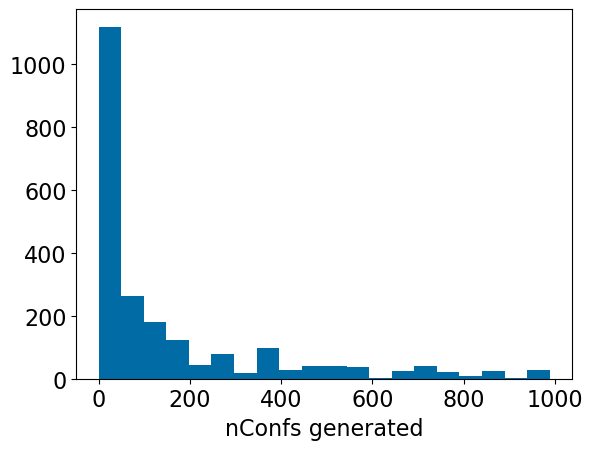

In [6]:
plt.Figure(figsize=(5,5))
plt.hist([x[2]-1 for x in d],bins=20);  #< it's -1 because we also have the crystal conformer
#plt.plot((0,1000),(0,1000),'k-');
plt.xlabel('nConfs generated');

nTABS is designed to be an upper limit on the number of conformers; let's check to confirm that this works:

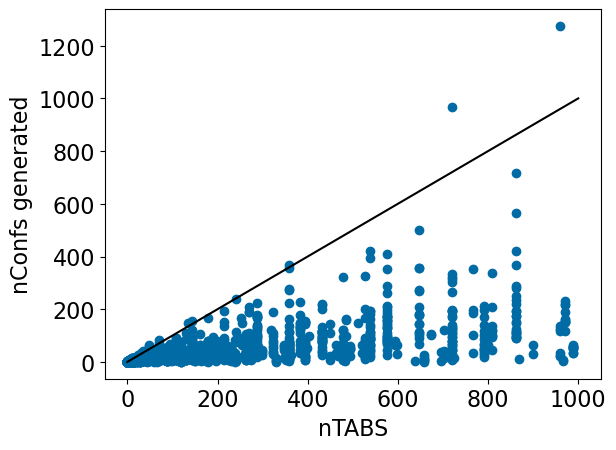

In [7]:
plt.Figure(figsize=(5,5))
plt.scatter([x[2]-1 for x in d],[x[1] for x in d]);
plt.plot((0,1000),(0,1000),'k-');
plt.xlabel('nTABS')
plt.ylabel('nConfs generated');

That works quite well in general, but let's look at the two outliers

In [8]:
d = %sql postgresql://localhost/lobster_112024 \
    select molregno,canonical_smiles,nconfs,ntabs from \
    (select molregno, count(conf_id) nconfs from generated_data.confgen group by (molregno)) t1 \
      join rdk.descriptors using (molregno) \
      join hashes using (molregno) \
    where ntabs<1000 and ntabs>600 and nconfs-ntabs>100;

In [9]:
len(d)

2

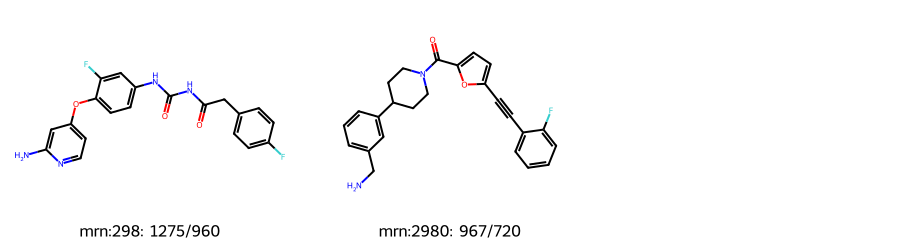

In [12]:
Draw.MolsToGridImage([Chem.MolFromSmiles(x[1]) for x in d],subImgSize=(300,250),
                    legends=[f'mrn:{x[0]}: {x[2]}/{x[3]}' for x in d])

The underestimate of the number of conformers for compound 2980 are due to the triple bond. This is a known limitation of the TABS algorithm that was discussed in the paper and that we're planning on working on. 

The "extra" conformers observed in compound 298 are due to a bug in the conformer generation code that leads to non-physical conformers, I hope to have this one fixed in a future RDKit release.

Actually retrieve all of the conformers to see how we did at finding the crystal conformer in our conformer ensembles:

In [50]:
d = %sql postgresql://localhost/lobster_112024 \
    select molregno,conf_id,molblock from conformers order by (molregno,conf_id) asc;

Find the conformer 
for each molecule that's closest to the crystal structure using RMSD as the metric:

In [51]:
from rdkit.Chem import rdMolAlign
accums = {}
r_mrn,r_cid,r_mb = d.pop(0)
r_mol = Chem.MolFromMolBlock(r_mb)
best = 1e8
best_cid = -1
for (mrn,cid,mb) in tqdm(d):
    mol = Chem.MolFromMolBlock(mb)
    if mrn==r_mrn:
        rms = rdMolAlign.GetBestRMS(r_mol,mol)
        if rms<best:
            best = rms
            best_cid = cid
    else:
        if best_cid > 0:
            accums[r_mrn] = (best,best_cid)
        r_mrn = mrn
        r_cid = cid
        r_mol = mol
        best = 1e8
        best_cid=-1


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 81315/81315 [00:14<00:00, 5507.62it/s]


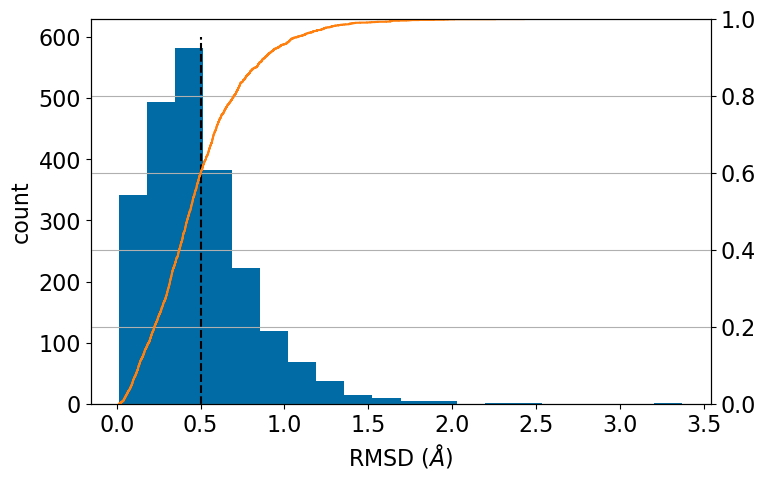

In [52]:
plt.figure(figsize=(8,5))
ax = plt.subplot(1,1,1)
plt.hist([x[0] for x in accums.values()],bins=20);
plt.plot((0.5,0.5),(0,600),'k--');
plt.xlabel('RMSD ($\\AA$)')
plt.ylabel('count')
ax2 = ax.twinx()
ax2.ecdf([x[0] for x in accums.values()],c='C1');
ax2.grid();

In [53]:
import numpy as np
np.quantile([x[0] for x in accums.values()],[0.6,0.8,0.9])

array([0.50160024, 0.69941346, 0.88421735])

60% of molecules are within 0.50A of the crystal structure, 80% are within 0.70A, and 90% are within 0.88A. That's pretty good.

# Comparing shape-similarity approaches

The RDKit has a couple of built-in methods for doing shape similarity. Let's compare those to each other on this data set:

Get a map from (nm,pdb) tuples to (molregno,confid,molblock):

In [4]:
d = %sql postgresql://localhost/lobster_112024 \
    select ligname,pdb,molregno,conf_id,molblock \
    from lobster_data.all_ligands join conformers using (molregno,conf_id);
ligs = {}
for nm,pdb,mrn,cid,mb in d:
    mol = Chem.MolFromMolBlock(mb,removeHs=False)
    mol_noh = Chem.MolFromMolBlock(mb)
    ligs[(nm,pdb.lower())] = (mrn,cid,mb,mol,mol_noh)

In [5]:
pairstats = %sql postgresql://localhost/lobster_112024 \
    select * from lobster_data.pair_stats
pairstats = list(pairstats.dicts())

Note that the scores for the ligand pairs in the LOBSTER data set are each present twice:
1. Ligand1 as reference, Ligand2 as probe
1. Ligand2 as reference, Ligand1 as probe

We can see this here:

In [40]:
len(pairstats)

72592

In [42]:
%sql postgresql://localhost/lobster_112024 \
    select count(*) from lobster_data.pair_stats where (ligname1,pdb1)>(ligname2,pdb2)

count
36296


In [6]:
from scipy import stats

In [43]:
def comparison_plot(pairstats,metric1,metric2,invert1=False,invert2=False):
    x1 = [x[metric1] for x in pairstats]
    if invert1:
        x1 = [1-x for x in x1]
        metric1 = f'1-{metric1}'
    x2 = [x[metric2] for x in pairstats]
    if invert2:
        x2 = [1-x for x in x2]
        metric2 = f'1-{metric2}'
    r,_ = stats.spearmanr(x1,x2)
    tau,_ = stats.kendalltau(x1,x2)

    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    plt.scatter(x1,x2,alpha=0.5,s=5)
    plt.xlabel(metric1)
    plt.ylabel(metric2)
    plt.title(f'rho={r:.2f}, tau={tau:.2f}');
    plt.subplot(1,2,2)
    plt.hexbin(x1,x2,cmap='Blues');
    plt.tight_layout()

Calculate USR scores:

In [46]:
from rdkit.Chem import rdMolDescriptors
for d in pairstats:
    m1 = ligs[(d['ligname1'],d['pdb1'])][3]
    m2 = ligs[(d['ligname2'],d['pdb2'])][3]
    usr1 = rdMolDescriptors.GetUSR(m1)
    usr2 = rdMolDescriptors.GetUSR(m2)
    d['USR'] = rdMolDescriptors.GetUSRScore(usr1,usr2)
    
    m1 = ligs[(d['ligname1'],d['pdb1'])][4]
    m2 = ligs[(d['ligname2'],d['pdb2'])][4]
    usr1 = rdMolDescriptors.GetUSR(m1)
    usr2 = rdMolDescriptors.GetUSR(m2)
    d['USR_noh'] = rdMolDescriptors.GetUSRScore(usr1,usr2)    

Calculate atom pair fingerprints using 3D distances instead of topological distances:

In [26]:
from rdkit.Chem import rdFingerprintGenerator
from rdkit import DataStructs
fpg = rdFingerprintGenerator.GetAtomPairGenerator(use2D=False)

for d in pairstats:
    m1 = ligs[(d['ligname1'],d['pdb1'])][3]
    m2 = ligs[(d['ligname2'],d['pdb2'])][3]
    fp1 = fpg.GetCountFingerprint(m1)
    fp2 = fpg.GetCountFingerprint(m2)
    d['AP3D'] = DataStructs.DiceSimilarity(fp1,fp2,returnDistance=True)
    
    m1 = ligs[(d['ligname1'],d['pdb1'])][4]
    m2 = ligs[(d['ligname2'],d['pdb2'])][4]
    fp1 = fpg.GetCountFingerprint(m1)
    fp2 = fpg.GetCountFingerprint(m2)
    d['AP3D_noh'] = DataStructs.DiceSimilarity(fp1,fp2,returnDistance=True)
 


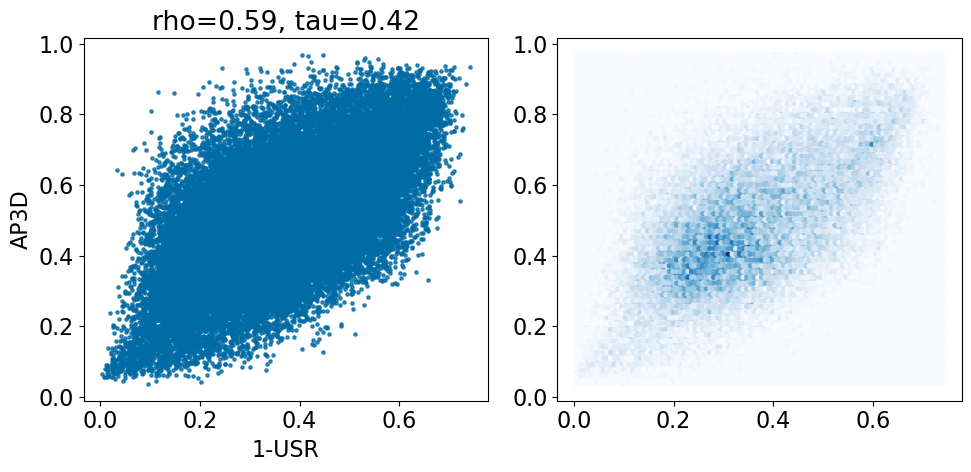

In [91]:
comparison_plot(pairstats,'USR','AP3D',invert1=True,invert2=False)

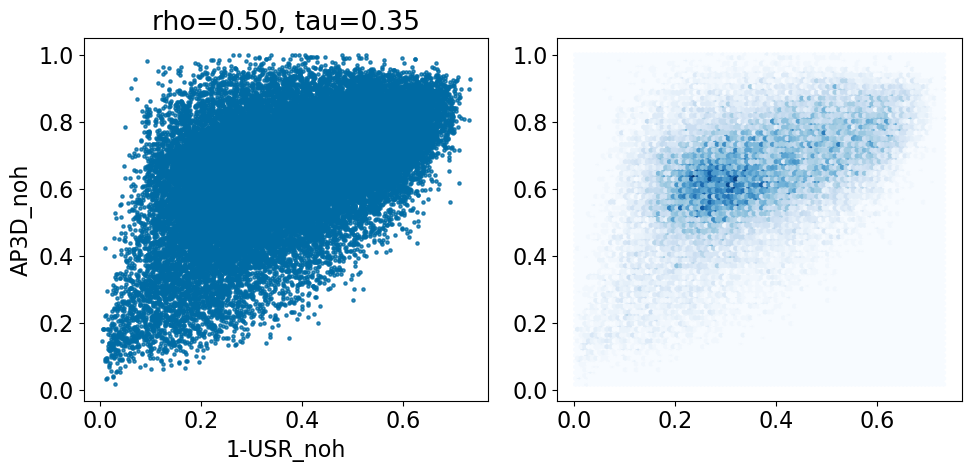

In [92]:
comparison_plot(pairstats,'USR_noh','AP3D_noh',invert1=True,invert2=False)

Finally, try the E3FP fingerprint (a 3D analog of the Morgan fingerprint) from [this paper](http://dx.doi.org/10.1021/acs.jmedchem.7b00696). The code is easily pip installable directly from [the github repo](https://github.com/keiserlab/e3fp). Thanks to the Keiser lab team for making this so easy!

It takes a while to run this one:

In [18]:
import logging
from e3fp.pipeline import fprints_from_mol
logging.disable(logging.INFO)

def get_fp(m):
    fp = fprints_from_mol(m,fprint_params={'counts':True})[0]
    rdkfp = DataStructs.ULongSparseIntVect(2**32)
    for k,v in fp.counts.items():
        rdkfp[int(k)] = v 
    return rdkfp

for d in pairstats:
    m1 = ligs[(d['ligname1'],d['pdb1'])][3]
    m2 = ligs[(d['ligname2'],d['pdb2'])][3]
    fp1 = get_fp(m1)
    fp2 = get_fp(m2)
    d['E3FP'] = DataStructs.DiceSimilarity(fp1,fp2,returnDistance=True)
    
    m1 = ligs[(d['ligname1'],d['pdb1'])][4]
    m2 = ligs[(d['ligname2'],d['pdb2'])][4]
    fp1 = get_fp(m1)
    fp2 = get_fp(m2)
    d['E3FP_noh'] = DataStructs.DiceSimilarity(fp1,fp2,returnDistance=True)
 


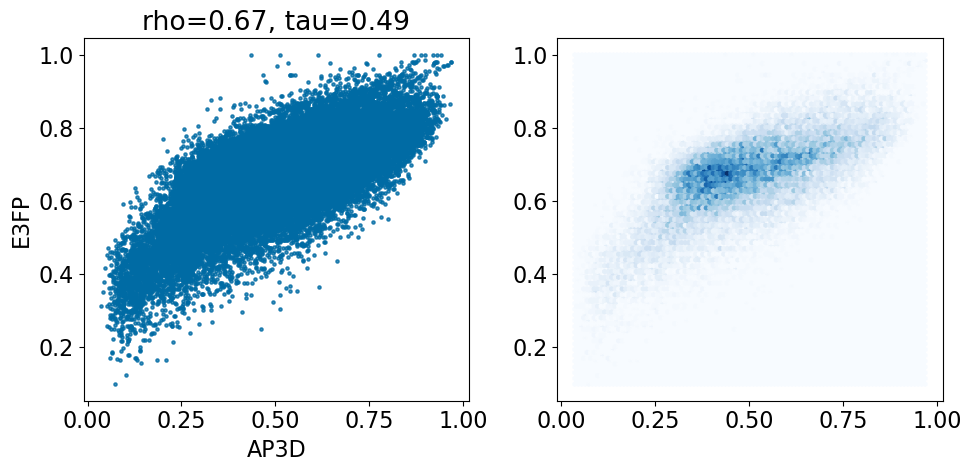

In [93]:
comparison_plot(pairstats,'AP3D','E3FP',invert1=False,invert2=False)

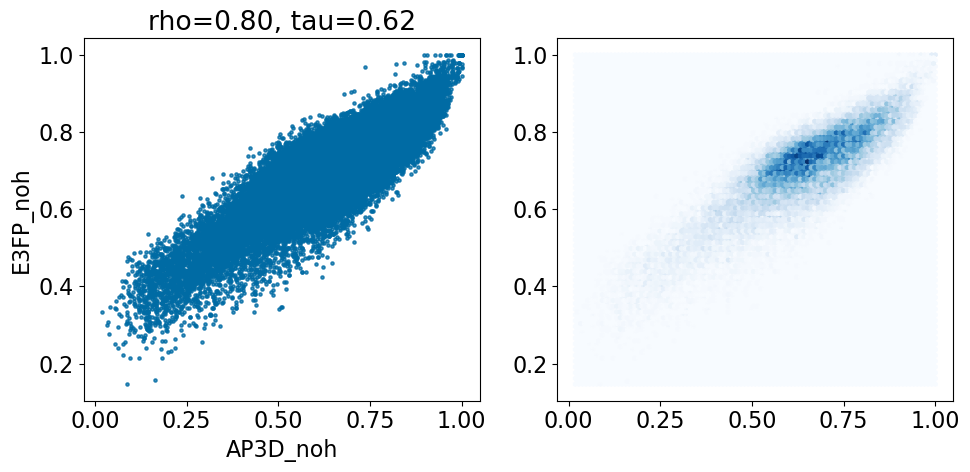

In [97]:
comparison_plot(pairstats,'AP3D_noh','E3FP_noh',invert1=False,invert2=False)

Save the results in the database so that we can work with them later:

In [98]:
cn = utils.connect(config=config) #< lwreg provides a convenience function to get a database connection
curs = cn.cursor()

curs.execute('create schema if not exists results')
curs.execute('create table if not exists results.shape_scores \
  (ligname1 text, pdb1 text, ligname2 text, pdb2 text,\
   USR float, USR_noh float, AP3D float, AP3D_noh float, E3P float, E3P_noh float)')
curs.execute('delete from results.shape_scores')
rows = [[r['ligname1'],r['pdb1'],r['ligname2'],r['pdb2'],\
         r['USR'],r['USR_noh'],r['AP3D'],r['AP3D_noh'],r['E3FP'],r['E3FP_noh']] for r in pairstats]
curs.executemany('insert into results.shape_scores values (%s,%s,%s,%s,%s,%s,%s,%s,%s,%s)',rows)
cn.commit()

That's it for this week